In [1]:
import os, sys, cv2
import pandas as pd

In [2]:
try:
    import ngif_romar.tools
except ModuleNotFoundError as error:
    # If not in path/installed, use relative import
    module_path = os.path.abspath(os.path.join(".."))
    sys.path.append(module_path)
    import ngif_romar.tools as tools

In [3]:
dataset_path = os.path.join("..", "data", "SN2", "20200930_1500_")
logfile_path = os.path.join(dataset_path, "Data.dat")
meta_dict, data_df = tools.read_data(logfile_path)
data_df.head()

,t,x,y,z,a,c,meltpoolSize,meltpoolTemp,LaserPower,stirrerValue_1,revolutionSpeed_1,powderGasFlow_1,stirrerValue_2,revolutionSpeed_2,powderGasFlow_2,flowWatch,meltpoolThreshold,protectionGlasTemperature
0,31201,0.0,0.0,0.0,0.0,0.0,8700,1752.0,2000,500,400,600,0,0,0,2872,506,19.2
1,31301,0.0,0.0,0.0,0.0,0.0,10465,1747.0,2000,500,400,600,0,0,0,2872,506,19.2
2,31401,0.0,0.0,0.0,0.0,0.0,10132,1760.0,2000,500,400,600,0,0,0,2872,506,19.2
3,31501,0.0,0.0,0.0,0.0,0.0,9926,1764.0,2000,500,400,600,0,0,0,2864,506,19.2
4,31601,0.0,0.0,0.0,0.0,0.0,10454,1767.0,2000,500,400,600,0,0,0,2864,506,19.2


Testing the part-frame coordinate rotation:

In [4]:
data_df=tools.post_process_log_data(data_df)

In [5]:
data_df.head()
data_df.columns

Index(['t', 'x', 'y', 'z', 'a', 'c', 'meltpoolSize', 'meltpoolTemp',
       'LaserPower', 'stirrerValue_1', 'revolutionSpeed_1', 'powderGasFlow_1',
       'stirrerValue_2', 'revolutionSpeed_2', 'powderGasFlow_2', 'flowWatch',
       'meltpoolThreshold', 'protectionGlasTemperature', 't(s)', 't(min)',
       'v_x(mm/ms)', 'v_y(mm/ms)', 'v_z(mm/ms)', '|v|(mm/ms)', 'phi(rad)',
       'r(mm)', 'phi_dot(rad/ms)', 'laser_on_time(ms)', 'laser_off_time(ms)',
       'xpart', 'ypart', 'zpart', 'toolpath_key'],
      dtype='object')

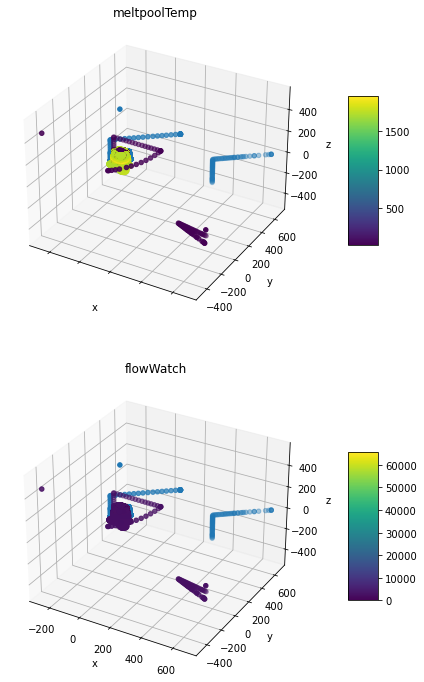

In [6]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
# 3D plotting
def ThreeDeePlot(df,*qs): # data = data directory, qs = quantit(ies)
    fig, axs = plt.subplots(len(qs), sharex=True,sharey=True, figsize=(8*len(qs),12),subplot_kw={"projection": "3d"}) # automatically create grid of subplots
    for i in range(len(qs)):
        if len(qs)!=1: # edge case of 1 quantity, in which case axs is not a list and axs[0] returns an error
            ax = axs[i]
        else:
            ax = axs
        q = qs[i]
        scat = ax.scatter(df['xpart'],df['ypart'],zs=df['zpart'],c=df[q])
        ax.set_xlabel('x');ax.set_ylabel('y');ax.set_zlabel('z')
        ax.set_title(q)
        ax.scatter(df['x'],df['x'],zs=df['z'])
        fig.colorbar(scat,ax=ax,shrink=0.5,aspect=5)

ThreeDeePlot(data_df,'meltpoolTemp', 'flowWatch')#, 'meltpoolSize','LaserPower','protectionGlasTemperature')

In [7]:
import numpy as np
def add_toolpath_key(data_df):
    """
    Adds a key identifying different toolpaths to pandas df
    
    Assumes "laser_on_time(ms)" column has already been added
    
    Args:
        - data_df : Pandas dataframe as produced by tools.read_data, with a laser_on_time(ms) column
    
    Returns:
        data_df
    """
    start_new_path = np.zeros(len(data_df))
    # Create a flag array of zero or one used to flag when laser switches off
    start_new_path[np.diff(data_df["laser_on_time(ms)"], prepend=0) < 0] = 1
    # This flag array can be used to designate different regions by cumsum 
    toolpath_key = np.cumsum(start_new_path)
    # Set the parts of the toolpath_key array where the laser is off to -1
    toolpath_key[data_df["laser_on_time(ms)"] == 0] = -1
    data_df["toolpath_key"] = toolpath_key
    return data_df
data_df = add_toolpath_key(data_df)
    

In [8]:
def obtain_subset(df, idx, laserOnTime=200):
    subset = df[
        (df["toolpath_key"] == idx)
        & (df["laser_on_time(ms)"] > 200)
    ]
    return subset

In [9]:
toolpath_idx = 31
subset=obtain_subset(data_df,toolpath_idx,laserOnTime=0)
print("Len of subset with toolpath idx {}: {}".format(toolpath_idx, len(subset)))

Len of subset with toolpath idx 31: 754


In [10]:
# Now for PCA work
from sklearn.preprocessing import StandardScaler
# first, normalise to mu=0, sigma=1
features=['meltpoolSize','meltpoolTemp','flowWatch','protectionGlasTemperature']
x=subset.loc[:, features].values # extract values
# Normalise the features
x = StandardScaler().fit_transform(x)
# Print line to check standardisation:
print(np.mean([i[0] for i in x]), np.std([i[0] for i in x]))

3.3359698734625394e-15 0.9999999999999999


In [11]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
print(np.cumsum(pca.explained_variance_ratio_))

pr_df = pd.DataFrame(data = principalComponents
             , columns = ['pc1', 'pc2'])
pr_df.head()

[0.45027113 0.70446612]


,pc1,pc2
0,-2.950583,-0.980033
1,-3.276021,-0.919477
2,-3.367564,-0.677249
3,-1.876755,-0.744083
4,-2.446882,-0.708186


Text(0, 0.5, 'PCA component 2')

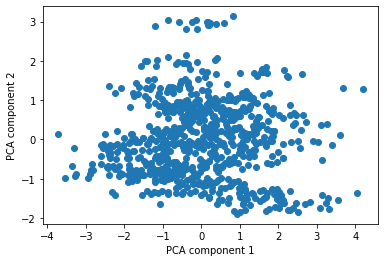

In [12]:
plt.scatter(pr_df['pc1'],pr_df['pc2'])
plt.xlabel('PCA component 1')
plt.ylabel('PCA component 2')

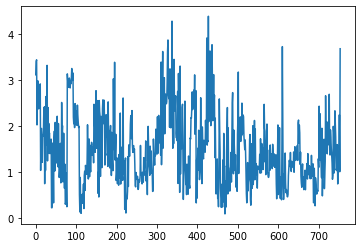

In [13]:
# 'PCA norm'
pr_df['norm']=pr_df.apply(lambda x: np.sqrt(x.dot(x)), axis=1)
plt.plot(pr_df['norm'])

Looking at individual toolpaths doesn't show me an obvious way of identifying 'bad' moments in the print.
What if instead we try and learn the average behaviour of a toolpath from the whole dataset? This could let us identify toolpaths of interest.
E.g., individual PCA components compared to average; variance in PCA norm compared to average;

Another idea: plotting the entire dataset on a 2D PCA axis suggests we could group toolpaths by cluster. This clustering classification could be cross referenced to see if the toolpaths are aggregated as we expect.

In [14]:
# PCA on whole data
features=['meltpoolSize','meltpoolTemp','flowWatch','protectionGlasTemperature']
w=data_df.loc[:, features].values # w for whole data
# Normalise the features
w = StandardScaler().fit_transform(w)
pca = PCA(n_components=2)
wpcs = pca.fit_transform(w)
print(np.cumsum(pca.explained_variance_ratio_))

w_df = pd.DataFrame(data = wpcs
             , columns = ['pc1', 'pc2'])
w_df.head()

[0.54387463 0.77691705]


,pc1,pc2
0,2.578286,-3.381006
1,2.332682,-3.341116
2,2.363743,-3.349322
3,2.387670,-3.355243
4,2.308501,-3.343564


Text(0, 0.5, 'PCA component 2')

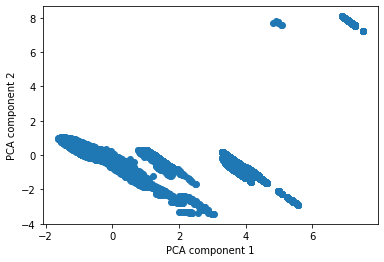

In [15]:
plt.scatter(w_df['pc1'],w_df['pc2'])
plt.xlabel('PCA component 1')
plt.ylabel('PCA component 2')

Clusting with DBSCAN:
DBSCAN defines "x is in a cluster" as "there are min_samples points within eps of x". I've used it previously and liked its performance.

In [16]:
# Clustering with DBSCAN
# based on the tutorial: https://scikit-learn.org/stable/auto_examples/cluster/plot_dbscan.html
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler

wdb=DBSCAN(eps=0.3,min_samples=10).fit(wpcs)

Note: clustering takes a long time! Less if you work on the pca component array rather than the equivalent dataframe

In [ ]:
core_samples_mask = np.zeros_like(wdb.labels_, dtype=bool)
core_samples_mask[wdb.core_sample_indices_] = True
labels = wdb.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

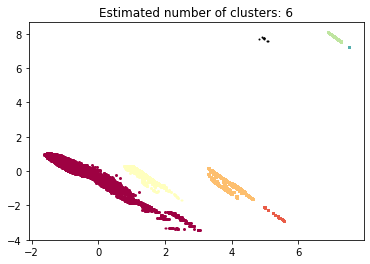

In [ ]:
# Plot cluster
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = wpcs[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='none', markersize=3)

    xy = wpcs[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='none', markersize=2)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

Clustering is pretty successful using default DBSCAN parameters.
Ideas:
* Identify worrisome clusters (by position, shape, size, ...). Presumably nozzle adhesions would 
* Distinguishing anomalies from nozzle adhesions. Assuming adhesions produce similar abnormal behaviour (cluster identification) over a continuous time interval (cross ref clusters to time series)
* Using clusters to get statistics of 'like' toolpaths, to analyse within a toolpath

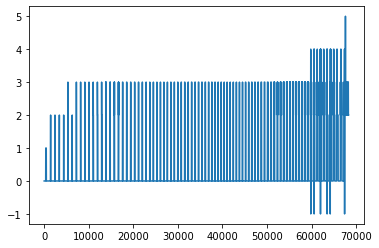

In [ ]:
# Temporal grouping
plt.plot(labels)
# TODO: this, but without laser power = 0 sections